<h3> Extract Insight Profile features </h3>
Insight profiles were copied directly from a .js script on the insight data science page. It contains the name of each fellow, their university, their demo project name, the company that hired them, and their job title. 
This notebook uses regular expressions to extract those features into a useable format.  


In [1]:
import re
import pandas as pd
import seaborn as svs

%matplotlib inline


In [2]:
def get_features(ind):
    '''
    ind: the string block containing containing the information for a single individual, 
    taken from the 'insight_profiles' file. See next cell for info on that.
    
    '''
    j_t = re.findall('font-weight:600;">(.*?)</div>', ind, re.DOTALL)
    if len(j_t) == 3:
        j_t = j_t[1].split(',')
    elif len(j_t) == 2:
        j_t = j_t[0].split(',')
    else:
        j_t = j_t[0].split(',')
    
    if len(j_t) == 2:
        job_title = j_t[0].strip()
        company = j_t[1]
    else:
        job_title = j_t[0].strip()
        company =  '?'
        
    ''' clean up company'''
    
    _c = re.sub('<br>', '', company)
    _c = re.sub('</br>', '', _c)
    _c = re.sub('[&#39;]', '', _c)
    company = _c.strip()
    
    project_title = re.findall('20px;">(.*?)</div>', ind, re.DOTALL)[0].strip()
    
    _back = re.search('Background(.*)', ind).group(1)
    university = _back.split('<br>')[1].strip()
    #university =re.findall('<br>(.*?)<br>', ind, re.DOTALL)[0].strip()
    background =re.findall('6px;">(.*?)<br>', ind, re.DOTALL)[0].strip()
    out_dict = {'job_title': job_title,
                'company':company, 
                'project_title':project_title,
               'university':university,
               'background':background}
    
    return out_dict


<h4>Extract all basic info from the flat file

In [3]:
with open('insight_profiles') as f:
    ftxt = f.read()

In [4]:
'''fellows_info is a list where each item is dictionary of features for that fellow'''
individuals =  re.findall ( '[*][*]/(.*?)/[*][*]', ftxt, re.DOTALL)
fellows_info = list()
for ind in individuals:
    fellows_info.append(get_features(ind))

<h4>Create a count of the number of fellows that were hired by each company


In [5]:
'''count the number of fellows that went to each company'''
company_set = set()
company_dict = {}
for fellow in fellows_info:
    com = fellow['company'] 
    if com in company_set:
        
        company_dict[com] += 1
    else:
        company_set.add(com)
        company_dict[com] = 1
        


In [6]:
company_series = pd.Series(company_dict).to_frame()
company_series.to_excel('companies.xlsx', sheet_name='s')


In [7]:
plot_series = company_series.sort(columns = [0], ascending = False)
plot_series.loc['Insight Data Science'] = 10
plot_series = plot_series.drop(['Insight','?'])
plot_series = plot_series.sort(columns = [0], ascending = False)


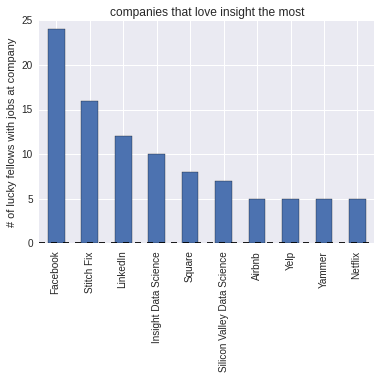

In [8]:
cur_plot = plot_series.plot(kind = 'bar')
cur_plot.set_xlim([-0.5, 9.5])
cur_plot.legend_.remove()
cur_plot.set_title('companies that love insight the most')
cur_plot.set_ylabel('# of lucky fellows with jobs at company')
fig = cur_plot.get_figure()
fig.patch.set_facecolor('white') #set the facecolor so it's not transparent

<h4> Plot the University that each fellow came from before Insight 

In [9]:
'''assuming that the fellows_info list already exists'''
univ_set = set()
univ_dict = {}

replace_dict=  {'Stanford':'Stanford University',
                'Yale':'Yale University',
                'Lawrence Berkeley': 'Lawrence Berkeley National Laboratory',
                'University of Waterloo':'University of Waterloo',
                'University of Texas':'University of Texas, Austin',
                'Caltech': 'California Institute of Technology',
                'UC Berkeley':'University of California, Berkeley',
                'U.C. Berkeley':'University of California, Berkeley',
                'Boston University':'Boston University',
                'MIT': 'Massachusetts Institute of Technology',
                'University of British Columbia':'University of British Columbia',
                'UC San Diego': 'University of California, San Diego',
                'UC Santa Cruz': 'University of California, Santa Cruz',
                'UC Davis': 'University of California, Davis'
               } 

for fellow in fellows_info:
    u = fellow['university'] 
    _u = re.sub('[&#47]', '', u)
    u = _u
    
    for k in replace_dict.keys():
        if k.lower() in u.lower():
            u = replace_dict[k]
    if u in univ_set:        
        univ_dict[u]['count'] += 1
    else:
        univ_set.add(u)
        univ_dict[u] = {'count':1}


In [22]:
df = pd.DataFrame(univ_dict)
df = df.drop(['University of California,'],axis=1,)

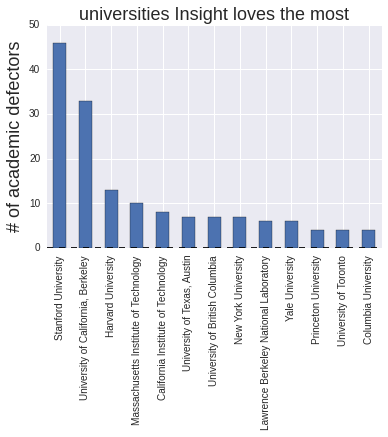

In [27]:
cur_plot = df.transpose().sort(columns = ['count'], ascending = False).plot(kind='bar')
cur_plot.set_xlim([-0.5, 12.5])
cur_plot.legend_.remove()
cur_plot.set_title('universities Insight loves the most', fontsize = 18)
cur_plot.set_ylabel('# of academic defectors', fontsize = 18)
fig = cur_plot.get_figure()
fig.patch.set_facecolor('white')

<h4> Now map the universities

In [11]:
with open('google.apik', 'r') as f:
    apikey = f.read()

In [12]:
def mapinfo(in_location, apikey):
    instr = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query=%s&key=%s' % (in_location,apikey)
    loc_info = requests.get(instr).json()
    return loc_info


In [13]:
call_api = False
if call_api:
    for k in univ_dict.keys():
        print 'trying %s' % k
        try:
            univ_dict[k]['map_info'] = mapinfo(k,apikey)
        except:
            print '%s exception' % k
else:
    print 'call_api is off'

call_api is off


In [14]:
'''to save API calls, only do this once if possible'''
import pickle
pickle.dump( univ_dict, open( "university.pkl", "wb" ) )

In [15]:
for k,v in univ_dict.iteritems():
    map_loc = v['map_info'][u'results'][0]['geometry']['location']
    univ_dict[k]['loc'] = map_loc

KeyError: 'map_info'

In [ ]:
import folium
from IPython.display import HTML
map_osm = folium.Map()


def inline_map(m, width=650, height=500):
    """Takes a folium instance and embed HTML."""
    m._build_map()
    srcdoc = m.HTML.replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed
exclusions = ['Signal Processing','One Acre Fund','Oracle'] #don't add these "universities"
for k,v in univ_dict.iteritems():
    if k not in exclusions:
        location = [v['loc']['lat'],v['loc']['lng']]

        place_count = '%s, # of Fellows: %d' % (k, v['count'])
        map_osm.simple_marker(location=location, popup=place_count)
    
map_osm.create_map(path='insight_universities.html')
inline_map(map_osm)